<a href="https://colab.research.google.com/github/Sebanthalas/fem-dnn/blob/main/Test_FEM_solver_JAN23_NSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
%cd drive/MyDrive/research
import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time
import os, sys, shutil
from google.colab import files
#!python -m pip install Tasmanian --user
!pip install hdf5storage
!

--2023-01-25 20:33:08--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4066 (4.0K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   3.97K  --.-KB/s    in 0s      

2023-01-25 20:33:08 (41.4 MB/s) - ‘/tmp/fenics-install.sh’ saved [4066/4066]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/bd824e7/releases/pybind11-install.s

In [3]:
%cd drive/MyDrive/research
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
# Other libraries
import scipy.io as sio
from fenics import *
#import Tasmanian
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy import linalg as la
import time, os, argparse, io, shutil, sys, math, socket
import scipy.io as sio
from dolfin import *
import sympy2fenics as sf
import random

/content/drive/MyDrive/research


In [4]:
'''
Mixed scheme of the Navier--Stokes--Brinkman equations
The domain is (a complex channel flow with obstacles

Manufactured smooth solutions
#######################################
strong primal form: 

 eta*u - lam*div(mu*eps(u)) + grad(u)*u + grad(p) = f  in Omega
                                           div(u) = 0  in Omega 

Pure Dirichlet conditions for u 
                                                u = u_D on Gamma

Lagrange multiplier to fix the average of p
                                           int(p) = 0

######################################

strong mixed form in terms of (t,sigma,u,gamma)

                 t + gamma = grad(u) 
lam*mu*t - dev(u otimes u) = dev(sigma)
        eta*u - div(sigma) = f
+ BC:
                         u = u_D on Gamma
+ trace of pressure:
 int(tr(sigma+u otimes u)) = 0
######################################

parametric  viscoscity: mu(x,y)
'''
def str2exp(s):
    return sf.sympy2exp(sf.str2sympy(s))

def coeff_extr(j):
    #This exctracts the coefficient of the different spaces
    # j is the index of the space:
    # j=o the vector space for uh
    # j=1 the space for  component of te11
    # j=2 the space for  component of te12
    # j=3 the space for  component of te21
    # j=4 the first  row of sigma
    # j=5 the second row of sigma
    # j=6 the lagrange multiplier (not uch important)
    # For this to work the nature of the space has to be the same
    W  = Function(Hh)
    #Getting the exact DOF location
    DoF_map   = Hh.sub(j).dofmap()
    DoF_index = DoF_map.dofs()
    AUX1 = W.vector().get_local()    # empty DoF vector 
    AUX2 = Sol.vector().get_local() # All DoF
    AUX1[DoF_index] = AUX2[DoF_index] # corresponding assignation
    W.vector().set_local(AUX1)       # corresponding assignation to empy vector
    coeff_vector = np.array(W.vector().get_local()) 
    return coeff_vector

parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["quadrature_degree"] = 4
parameters["allow_extrapolation"]= True
parameters["refinement_algorithm"] = "plaza_with_parent_facets"
fileO = XDMFFile("outputs/complexChannelFlow-AFW.xdmf")
fileO.parameters["functions_share_mesh"] = True
fileO.parameters["flush_output"] = True


# ==============================================================
# Define the parameters for the PDE and SG points
# ==============================================================
# All parameters
default_parameters = {
  'trial_': 1,
  'example' : 'logKL_expansion', #logKL_expansion
  'input_dim': 6
}
params = default_parameters

# ==============================================================
# random samples
# ==============================================================
_trial  = params['trial_']
example = params['example']
np_seed = _trial
np.random.seed(np_seed)
input_dim = params['input_dim']
d = input_dim       # parametric dimension
# ==============================================================
# ****** Constant coefficients ****** #
# ==============================================================

f    = Constant((0,1))
ndim = 2
Id   = Identity(ndim)
lam  = Constant(1)
# ==============================================================
# *********** Variable coefficients ********** #
 # ==============================================================
uinlet = Expression(('0','x[0]*(1.-x[0])'), degree = 2)
eta    = Expression('0.1 + 0.01*sin(x[0])*sin(x[1])', degree=3)

l      = 1 
mesh = Mesh("meshes/complex_channel/ComplexChannel.xml")
bdry = MeshFunction("size_t", mesh, "meshes/complex_channel/ComplexChannel_facet_region.xml")
wall = 30; inlet=10; outlet=20;
nn   = FacetNormal(mesh)
tan  = as_vector((-nn[1],nn[0])) # DIMMMMMM
    
ds = Measure("ds", subdomain_data = bdry)
dx = Measure("dx", domain=mesh)
#dS = Measure("dS", subdomain_data = bdry)

Ht   = VectorElement('DG', mesh.ufl_cell(), l+1, dim = 3)
Hsig = FiniteElement('BDM', mesh.ufl_cell(), l+1)# In FEniCS, Hdiv tensors need to be defined row-wise
Hu   = VectorElement('DG', mesh.ufl_cell(), l)
Hgam = FiniteElement('DG', mesh.ufl_cell(), l)    

Hh = FunctionSpace(mesh, MixedElement([Ht,Hsig,Hsig,Hu,Hgam]))
# ==============================================================
# spaces to project for visualisation only
# ==============================================================
Ph = FunctionSpace(mesh,'CG',1)
Th = TensorFunctionSpace(mesh,'CG',1)
print (" ****** Total DoF = ", Hh.dim())  
# ==============================================================
# *********** Trial and test functions ********** #
# ==============================================================
Trial = TrialFunction(Hh)
Sol   = Function(Hh) 
t_, sig1, sig2,u,gam_ = split(Sol)
s_, tau1, tau2,v,del_ = TestFunctions(Hh)

t = as_tensor(((t_[0], t_[1]),(t_[2],-t_[0])))
s = as_tensor(((s_[0], s_[1]),(s_[2],-s_[0])))

sigma = as_tensor((sig1,sig2))
tau   = as_tensor((tau1,tau2))

gamma = as_tensor(((0,gam_),(-gam_,0)))
delta = as_tensor(((0,del_),(-del_,0)))
# ==============================================================
# ********** Boundary conditions ******** #
# ==============================================================
zero = Constant((0.,0.))
#bcsig1 = DirichletBC(Hh.sub(4), zero, bdry, wall)
#bcsig2 = DirichletBC(Hh.sub(5), zero, bdry, wall)
#bcD = [bcsig1,bcsig2]

nitsche = Constant(1.e4)
for m in [4]:
    All_Train_coeff   = []
    All_Train_coeff_p = []
    _L4unorm= []
    _L2tnorm= []
    _L2pnorm= []
    _L2snorm= []
    d = params['input_dim'] # parametric dimension
    y_in_train = 2.0*np.random.rand(d,m) - 1.0  # training points    
    ndim = 2
    # Generate the training data
    for i in range(m):
      coeff_each_m = []
      coeff_each_m_p = []
      # time
      t_start = time.time()
      # Paramters
      z = y_in_train[:,i]
      # ******* Exact solutions for error analysis ****** 
      #================================================================
      # The viscosity of the fluid depends on the parameters
      #================================================================
      
      if example == 'logKL_expansion':
         pi = 3.14159265359
         pi_s = str(pi)
         L_c = 1.0/8.0
         L_p = np.max([1.0, 2.0*L_c])
         L_c_s = str(L_c)
         L_p_s = str(L_p)
         L = L_c/L_p
         L_s = str(L)      
         string = '5.0+sqrt(sqrt(' + pi_s + ')*' + L_s + '/2.0)*' + str(z[0])
         for j in range(2, d):
           term = str(z[j-1]) + '*sqrt(sqrt(' + pi_s + ')*' + L_s + ')*exp(-pow(floor('
           term = term + str(j) + '/2.0)*' + pi_s + '*' + L_s + ',2.0)/8.0)' 
           if j % 2 == 0:
             term = term + '*sin(floor(' + str(j) + '/2.0)*' + pi_s + '*x/' + L_p_s + ')'
           else:
             term = term + '*cos(floor(' + str(j) + '/2.0)*' + pi_s + '*x/' + L_p_s + ')'
           string = string + '+' + term
         string = 'exp(' + string + ')'
      else:# use a simple example where only the first two dimensions have x dependence
        string = 1/2
        string = '5.0+exp(' + str(z[0]) + '+' + str(z[1]) + '+' + str(z[2]) + '+'+ str(z[3]) +' )' 
        
      mu = Expression(str2exp(string), degree=2, domain=mesh)
      #mu = Constant(string)
      #mu = Constant(1/50)
      #================================================================
      # Boundary condition
      #================================================================ 
      # *************** Variational forms ***************** #
      a   = lam*mu*inner(t,s)*dx 
      b1  = - inner(sigma,s)*dx
      b   = - inner(outer(u,u),s)*dx
      b2  = inner(t,tau)*dx
      bbt = dot(u,div(tau))*dx + inner(gamma,tau)*dx
      bb  = dot(div(sigma),v)*dx + inner(sigma,delta)*dx
      cc  = eta * dot(u,v)*dx

      #+ xi*tr(tau+outer(v,v))*dx ???
      AA = a + b1 + b2 + b + bbt + bb - cc 
      FF = dot(tau*nn,uinlet)*ds(inlet) - dot(f,v)*dx
      Nonl = AA - FF + nitsche * dot((sigma+outer(u,u))*nn,tau*nn)*ds(outlet)
      #Nonl = AA - FF + nitsche * dot((sigma)*nn,tau*nn)*ds(outlet)

      Tangent = derivative(Nonl, Sol, Trial)
      Problem = NonlinearVariationalProblem(Nonl, Sol, J=Tangent)
      Solver  = NonlinearVariationalSolver(Problem)
      Solver.parameters['nonlinear_solver']                    = 'newton'
      Solver.parameters['newton_solver']['linear_solver']      = 'mumps'
      Solver.parameters['newton_solver']['absolute_tolerance'] = 1e-8
      Solver.parameters['newton_solver']['relative_tolerance'] = 1e-8
      Solver.parameters['newton_solver']['maximum_iterations'] = 25
          
      Solver.solve()
      th_, sigh1, sigh2,uh,gamh_ = Sol.split()
          
      th = as_tensor(((th_[0], th_[1]),(th_[2],-th_[0])))
      sigmah = as_tensor((sigh1,sigh2))
      gammah = as_tensor(((0,gamh_),(-gamh_,0)))

      ph = project(-1/ndim*tr(sigmah + outer(uh,uh)),Ph) 

      sig_v = project(sigmah, Th)
      t_v = project(th, Th) 
      g_v = project(gammah, Th)
      coeff_each_m_p = ph.vector().get_local()
      All_Train_coeff_p.append(coeff_each_m_p)
      #
      num_subspaces = Sol.num_sub_spaces()-1
      for j in range(num_subspaces):
        coef_one_trial = coeff_extr(j)
        coeff_each_m.append(coef_one_trial)
      All_Train_coeff.append(coeff_each_m)
      print('====================================================================')
      print('i = ', i, ' ', y_in_train[:,i])
      print('====================================================================')
      L4unorm  = sqrt(sqrt(assemble( ((uh)**2)**2*dx)))
      L2tnorm  = sqrt(assemble( (th)**2*dx ))
      L2pnorm  = sqrt(assemble((ph)**2*dx) ) 
      L2snorm  = sqrt(assemble((sigmah)**2*dx) ) 
      print(L4unorm,L2tnorm,L2pnorm)
      _L4unorm.append(L4unorm)
      _L2tnorm.append(L2tnorm)
      _L2pnorm.append(L2pnorm)
      _L2snorm.append(L2snorm)

     
      if i == 0:
        K = len(All_Train_coeff[0][0])
        print('FE degrees of freedom K = ',K)
    print('Generated inputs of size: ', y_in_train.shape)
    print('Generated outputs of size: ', coef_one_trial.shape[0])

i =  0   [-0.16595599  0.44064899 -0.99977125 -0.39533485]
0.6764572339626291 6.486140765497609 207.68723384533868
FE degrees of freedom K =  17554
Generated inputs of size:  (4, 1)
Generated outputs of size:  17554
Generating the testing data
Generated inputs of size:  (4, 0)
Generated outputs of size:  (17554,)


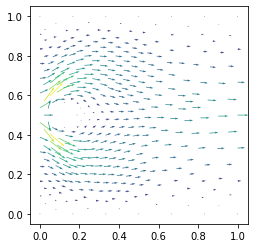

NameError: ignored